In [1]:
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
# Taken fron http://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
state_abbreviations = {
        'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MS': 'Mississippi', 'MT': 'Montana', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming'
}

states = list(state_abbreviations.values())
states.sort()

In [3]:
# miles in millions of miles
# electricity consumption in million kWh (ESRCP)
# electricity price in Dollars per million Btu (ESRCD)
# gasoline price in Dollars per million Btu (MGACD)
state_data = {'miles': {}, 'electricity_consumption': {}, 'electricity_price': {}, 'gasoline_price' : {}}

In [4]:
# parse datasets for relevant information
with open('datasets/TVT2017.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    header = next(reader)
    for row in reader:
        state = row[0]
        state_data['miles'][state] = sum(map(lambda x: float(x.replace(',','')), row[1:]))

with open('datasets/complete_seds.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    header = next(reader)
    for row in reader:
        MSN = row[1]
        try:
            state = state_abbreviations[row[2]]
        except:
            continue
        year = row[3]
        value = float(row[4])
        if (year != '2017'):
            continue
        if (MSN == 'ESRCP'):
            state_data['electricity_consumption'][state] = value
        if (MSN == 'ESRCD'):
            state_data['electricity_price'][state] = value
        if (MSN == 'MGACD'):
            state_data['gasoline_price'][state] = value        

In [5]:
price_compare = list(map(lambda s: state_data['electricity_price'][s]/state_data['gasoline_price'][s], states))

In [6]:
# EPA ranges from https://www.fueleconomy.gov/feg/Find.do
# BTU conversions from:
# Gasoline: https://www.eia.gov/totalenergy/data/monthly/pdf/sec13_4.pdf
# Electricity: https://www.eia.gov/totalenergy/data/monthly/pdf/sec13_7.pdf

# Tesla 3: 26 kWh / 100 mi
# Charge efficiency is ~85% (https://ncst.ucdavis.edu/wp-content/uploads/2018/09/Kong_NCST-Fellowship-Report.pdf)
# This translates to 30.59 kWh / 100 mi in terms of charging
# Convert to mBTU / 100 mi -> 30.59 kWh / 100 mi (0.003412 mBTU / kWh)
# Toyota Camry: 2.9 gallons / 100 mi (https://www.carfax.com/blog/2018-best-selling-cars-by-category)
# Convert to mBTU / 100 mi -> 2.9 gallons / 100 mi (5.054 mBTU / 42 gallons) 

efficiency_adjustment = (26 / .85 * 0.003412) / (2.9 * 5.054 / 42)

price_compare_adjusted = list(map(lambda x: x*efficiency_adjustment, price_compare))

In [7]:
electricity_demand = list(map(lambda s: 100 * state_data['miles'][s] * (float(26)/85)/state_data['electricity_consumption'][s], states))

In [8]:
plt.rcParams['font.size'] = 12
# plt.rcParams['axes.titlesize'] = 12
# plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['figure.figsize'] = (7,7)

x = np.arange(len(states))  # the label locations
width = 0.35  # the width of the bars

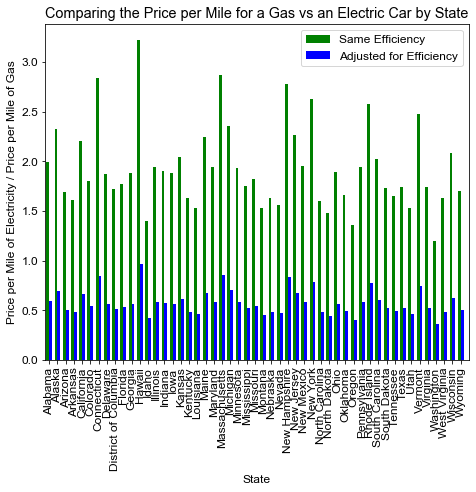

In [9]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, price_compare, width, color='Green', label='Same Efficiency')
rects2 = ax.bar(x + width/2, price_compare_adjusted, width, color='Blue', label='Adjusted for Efficiency')

ax.set_xlim( (-0.5, 0.0 + len(states) ) )

ax.set_ylabel('Price per Mile of Electricity / Price per Mile of Gas')
ax.set_title('Comparing the Price per Mile for a Gas vs an Electric Car by State')
ax.set_xlabel('State')
ax.set_xticks(x)
ax.set_xticklabels(states, verticalalignment="top", horizontalalignment="center", rotation=90)
ax.legend()

fig.tight_layout()

# plt.savefig( "Price-Comparison.pdf", bbox_inches="tight" )
plt.show()

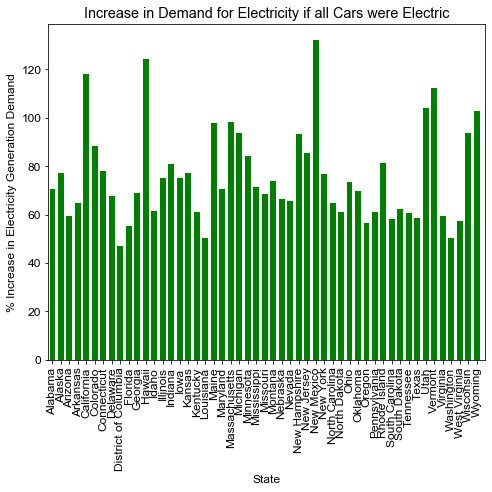

In [10]:
fig, ax = plt.subplots()
rects1 = ax.bar(x, electricity_demand, width*2, color='Green', label='Electricity Demand')

ax.set_xlim( (-0.5, 0.0 + len(states) ) )

ax.set_ylabel('% Increase in Electricity Generation Demand')
ax.set_title('Increase in Demand for Electricity if all Cars were Electric')
ax.set_xlabel('State')
ax.set_xticks(x)
ax.set_xticklabels(states, verticalalignment="top", horizontalalignment="center", rotation=90)

fig.tight_layout()

# plt.savefig( "Electricity-Demand.pdf", bbox_inches="tight" )
plt.show()

In [11]:
pattern = re.compile(r'.*Net generation : (.+) : (.+) : electric power.*annual.*"2017",([0-9\.]+)')
power_data = {}

# parse datasets for relevant information
with open('datasets/ELEC.txt', 'r') as textfile:
    for line in textfile:
        m = pattern.match(line)
        if m:
            fueltype = m.group(1)
            state = m.group(2)
            if (state == 'District Of Columbia'):
                state = 'District of Columbia'
            pgen = float(m.group(3))
            try:
                power_data[state]
            except:
                power_data[state] = {'conventional hydroelectric': 0.0, 'other renewables (total)': 0.0, 'all fuels': 0.0}

            power_data[state][fueltype] = pgen

In [14]:
percent_renewable = list(map(lambda s: 100.0*(power_data[s]['conventional hydroelectric'] + power_data[s]['other renewables (total)'])/power_data[s]['all fuels'], states))

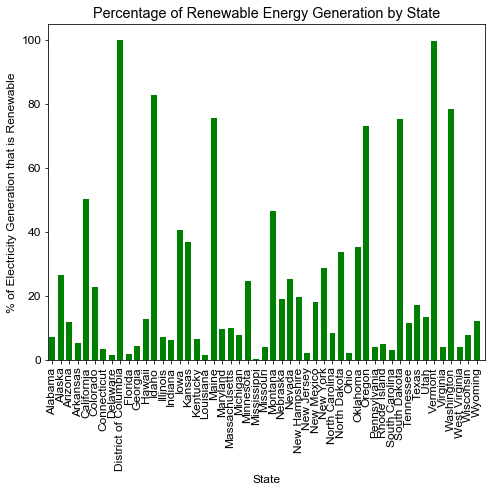

In [15]:
fig, ax = plt.subplots()
rects1 = ax.bar(x, percent_renewable, width*2, color='Green', label='Electricity Demand')

ax.set_xlim( (-0.5, 0.0 + len(states) ) )

ax.set_ylabel('% of Electricity Generation that is Renewable')
ax.set_title('Percentage of Renewable Energy Generation by State')
ax.set_xlabel('State')
ax.set_xticks(x)
ax.set_xticklabels(states, verticalalignment="top", horizontalalignment="center", rotation=90)

fig.tight_layout()

# plt.savefig( "Percent-Renewable.pdf", bbox_inches="tight" )
plt.show()